In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as color
import matplotlib.gridspec as gridspec
import numpy as np
import random
import warnings
warnings.filterwarnings("ignore")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


To reduce work later on, the code will be written to be flexible in terms of boundary conditions:
- The boundary conditions will be inputted using a boolean mask
- Using the boolean mask, another function will initialize the grid and set the boundary conditions
- The relaxation method function will only change the values of the pixels where the mask is not applied

First, defining a square mask around the center of the grid:

In [2]:
def square(radius):
    grid_size = 2 * radius 
    mask = np.zeros((grid_size, grid_size), dtype=bool)
    square_size = radius // 4 # Length of square's side should be a quarter of the length of the radius

    start = (grid_size - square_size) // 2
    end = start + square_size
    
    mask[start:end, start] = True 
    mask[start:end, end-1] = True
    mask[start, start:end] = True
    mask[end-1, start:end] = True
    
    return mask

For the boundary around the grid, a `periodicity` parameter is built-in; this will allow periodic boundary conditions to be toggled: (will be useful in question 4)

In [46]:
def periodic(radius, periodicity=False):
    grid_size = 2 * radius
    mask = np.zeros((grid_size, grid_size), dtype=bool)
    
    if periodicity == False: # Non-periodic boundary conditions
        mask[:, 0] = True
        mask[:, -1] = True
        mask[0, :] = True
        mask[-1, :] = True
    elif periodicity == True: # Periodic boundary conditions
        mask[:, 0] = True
        mask[:, -1] = True
    else:
        raise ValueError("periodicity must be boolean value")
    

    return mask


`initialize_grid` function to set initial potential values:

In [47]:
def initialize_grid(radius, shape_mask):
    grid_size = 2 * radius 
    V = np.zeros((grid_size, grid_size))
    V[shape_mask] = 1 # For the shapes (not on boundary), set potential to 1
    
    return V

To prevent infinite loops, introduce a new parameter for maximum iteration size. This will also help keep count of number of iterations needed to converge:

In [48]:
def relaxation_method(V, boundary_mask, tolerance=0.1, maxiter = 1000000):
    
    for iteration in range(maxiter):
        V_old = V.copy()

        V[~boundary_mask] = 0.25 * (np.roll(V_old, 1, axis=0) + np.roll(V_old, -1, axis=0) + 
        np.roll(V_old, 1, axis=1) + np.roll(V_old, -1, axis=1))[~boundary_mask] # Apply changes only to pixels where mask doesn't apply
        
        if np.nanmax(np.abs((V-V_old)/V)*100) < tolerance: # If the percent diff. between new and old is less than tolerance, break
            print(f"Converged after {iteration+1} iterations")
            break

    return V

Plotting function to reduce redundancy:

In [6]:
def plot(V_initial, V_final, radius):
    gsize = radius * 2
    ycenter = gsize // 2
    Vcenter = V_final[:, ycenter]

    fig = plt.figure(figsize=(10, 5))
    gs = fig.add_gridspec(2, 2)

    ax1 = fig.add_subplot(gs[0, 0])
    im1 = ax1.imshow(V_initial, origin='lower', extent=[-radius, radius, -radius, radius])
    fig.colorbar(im1, ax=ax1)
    ax1.set_xlabel('$x$')
    ax1.set_ylabel('$y$')
    ax1.set_title('Start')

    ax2 = fig.add_subplot(gs[1, 0])
    im2 = ax2.imshow(V_final, origin='lower', extent=[-radius, radius, -radius, radius])
    fig.colorbar(im2, ax=ax2)
    ax2.set_xlabel('$x$')
    ax2.set_ylabel('$y$')
    ax2.set_title('Finish')

    ax3 = fig.add_subplot(gs[:, 1])
    ax3.plot(range(-radius, radius), Vcenter)
    ax3.set_xlabel('$y$')
    ax3.set_ylabel('$V$')
    ax3.set_title('Central Cut')

    plt.tight_layout()
    plt.show()

# 1)

Define a function to call all previous functions (so I don't have to type it out every single time):

In [7]:
def callV1(radius):
    square_mask = square(radius)
    boundary_mask = periodic(radius)
    Vstart = initialize_grid(radius, square_mask)
    Vend = relaxation_method(Vstart.copy(), boundary_mask | square_mask)
    return Vstart, Vend, radius

Converged after 625 iterations


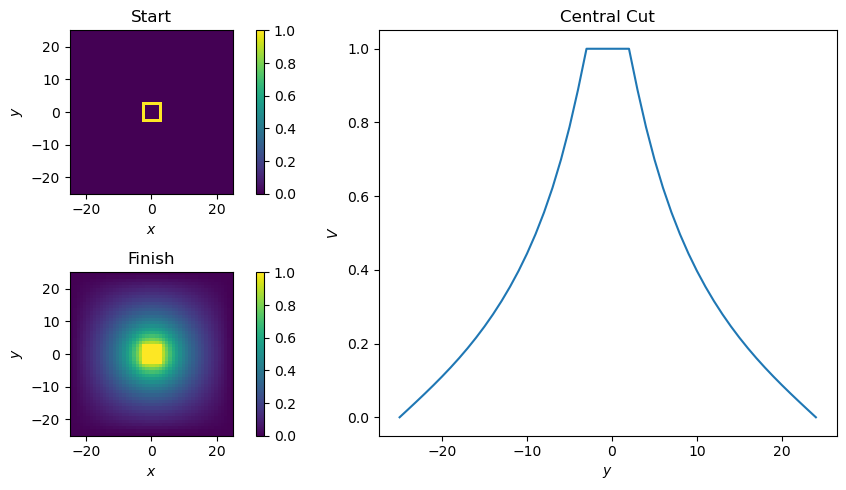

In [8]:
A, B, C = callV1(25)
plot(A,B,C)

# 2)

For a radius of 25:

Converged after 625 iterations


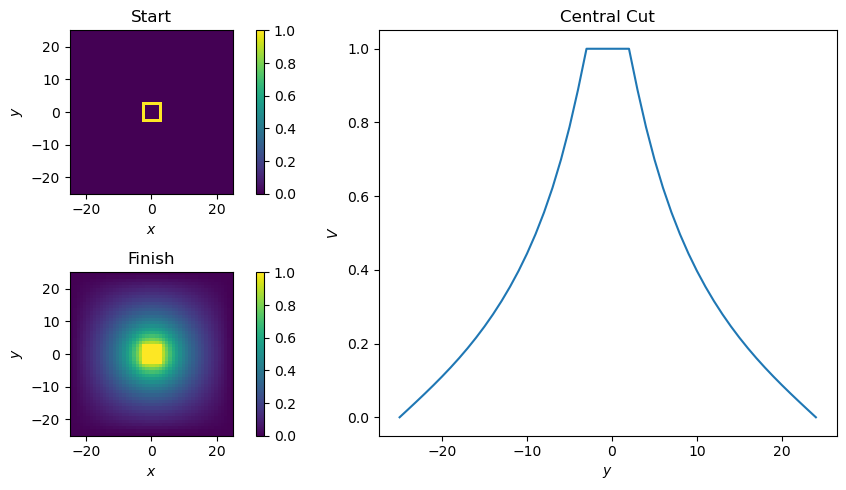

In [9]:
A, B, C = callV1(25)
plot(A,B,C)

For a radius of 50:

Converged after 1535 iterations


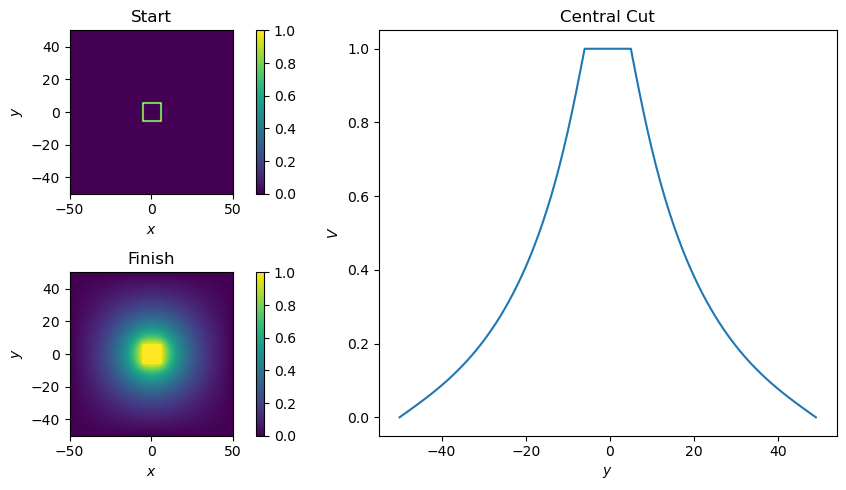

In [10]:
D, E, F = callV1(50)
plot(D,E,F)

For a radius of 100:

Converged after 3555 iterations


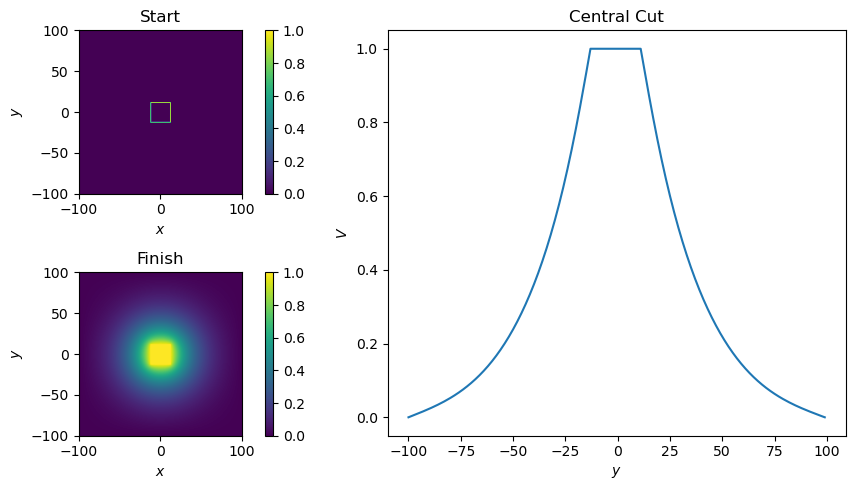

In [11]:
G, H, I = callV1(100)
plot(G,H,I)

- Radius of 25 $\to$ 625 iterations to converge.
- Radius of 50 $\to$ 1535 iterations to converge.
- Radius of 100 $\to$ 3555 iterations to converge.

It seems that the number of iterations tends to increase linearly (or at least sublinearly). For a radius $N$ the corresponding grid size is $(2N)^2$; as $N$ increases, the grid size increases quadratically. This means the number of iterations to converge must increase quadratically (with respect to the grid size). This makes sense intuitively, as the relaxation method involves updating each point based on its neighbors, and for each pixel added there are four extra computations needed.

The total number of computations, being the product of the number of grid points and the number of iterations, increases cubically with the radius; $C(N) \propto R^3$. 

# 3)

Since I can't think of anything that creative, instead let's randomly generate small circles and squares across the grid. To do this, I need to:
- Change the square mask generating function so that it can be generated at different sizes and in different places
- Create a circle mask generating function that generates circular conductors at different places with different sizes
- Make sure there is no overlap between them (looks better that way, I think)
- Randomly generate squares and circles inside the grid

In [12]:
def squarec(radius, center, size):
    grid_size = 2 * radius 
    mask = np.zeros((grid_size, grid_size), dtype=bool)
    half_size = size // 2
    start_x = max(0, center[0] - half_size)
    end_x = min(grid_size, center[0] + half_size + 1)
    start_y = max(0, center[1] - half_size)
    end_y = min(grid_size, center[1] + half_size + 1)
    
    mask[start_x:end_x, start_y] = True
    mask[start_x:end_x, end_y-1] = True
    mask[start_x, start_y:end_y] = True
    mask[end_x-1, start_y:end_y] = True
    
    return mask

In [13]:
def circlec(radius, center, size):
    grid_size = 2 * radius 
    mask = np.zeros((grid_size, grid_size), dtype=bool)
    circle_radius = size // 2
    y, x = np.ogrid[-center[0]:grid_size-center[0], -center[1]:grid_size-center[1]]
    mask_area_outer = x**2 + y**2 <= circle_radius**2 # Apply circular mask
    mask_area_inner = x**2 + y**2 <= (circle_radius - 1)**2
    mask[mask_area_outer] = True
    mask[mask_area_inner] = False
    return mask

Make sure there is no overlap:

In [14]:
def is_overlap(mask, new_mask):
    return np.any(mask & new_mask)

In [15]:
def random_boundary_mask(radius, num_shapes, max_size):
    grid_size = 2 * radius 
    mask = np.zeros((grid_size, grid_size), dtype=bool)
    shapes = ['square', 'circle']
    size = max(1, radius // max_size)  

    for _ in range(num_shapes): # Randomly choose a shape from list and where it should be located
        shape_type = random.choice(shapes)
        while True:
            center = (random.randint(0, grid_size-1), random.randint(0, grid_size-1))
            if shape_type == 'square':
                new_mask = squarec(radius, center, size)
            elif shape_type == 'circle':
                new_mask = circlec(radius, center, size)
            
            if not is_overlap(mask, new_mask):
                mask |= new_mask # Once conditions are satisfied, add to mask and break loop
                break

    return mask

Define another function to call functions:

In [16]:
def callV2(radius, num_shapes, max_size):
    shape_mask = random_boundary_mask(radius, num_shapes, max_size)
    boundary_mask = periodic(radius)
    Vstart = initialize_grid(radius, shape_mask)
    Vend = relaxation_method(Vstart.copy(), boundary_mask | shape_mask)
    return Vstart, Vend, radius

Each run of the following cell will produce a different arrangement of charges:

Converged after 753 iterations


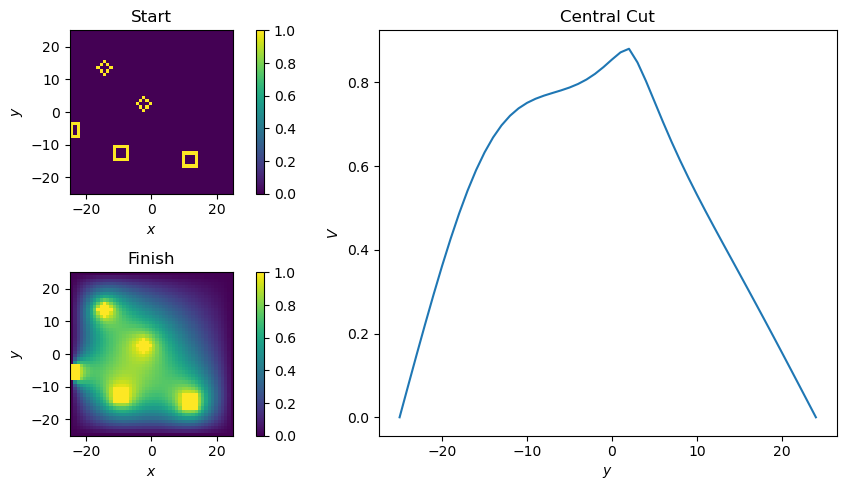

In [50]:
J, K, L = callV2(25, 5, 5)
plot(J, K, L)

# 4)

Because of the "infrastructure" already set up, I just need to create two functions:
- One to create a mask for an "infinite" conducting plate
- Another to initialize and set initial potentials

Inside of the first function, I've created a parameter `strength` that will tell the initialize function whether or not to set the initial potential to +1 or -1 and set the initial position of the plates accordingly:

In [18]:
def conduct_plane(radius, loc, strength):
    grid_size = radius*2
    mask = np.zeros((grid_size, grid_size), dtype=bool)

    if strength == 1:
        mask[-int(radius - loc*radius), :] = True
    elif strength == -1:
        mask[int(radius-loc*radius), :] = True
    else:
        raise ValueError("Strength must be either 1 or -1")
    
    return mask, strength

Initialize grid by setting conducting plate's original potential to the strength:

In [19]:
def grid_init(radius, line_mask, strength):
    grid_size = 2 * radius 
    
    V = np.zeros((grid_size, grid_size))
    
    V[line_mask] = strength

    return V

Create a function to call functions:

In [42]:
def callV3(radius):
    line1, strength1 = conduct_plane(radius, loc=0.2, strength=-1)
    line2, strength2 = conduct_plane(radius, loc=0.2, strength=1)
    boundary_mask = periodic(radius, periodicity=True)
    Vstart = grid_init(radius, line1, strength1) + grid_init(radius, line2, strength2) # There are two masks -> add to get total mask
    Vend = relaxation_method(Vstart.copy(), boundary_mask | line1 | line2)
    return Vstart, Vend, radius

For a radius of 100:

Converged after 2287 iterations


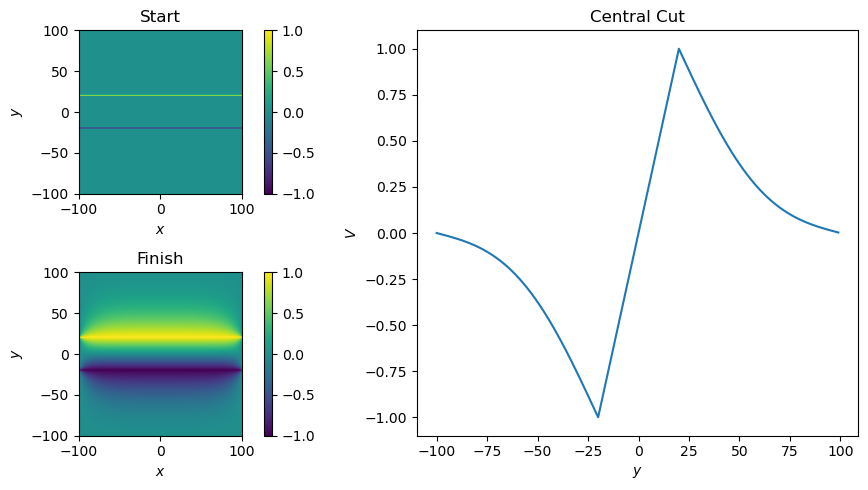

In [43]:
M, N, O = callV3(100)
plot(M, N, O)

For a radius of 300:

Converged after 7343 iterations


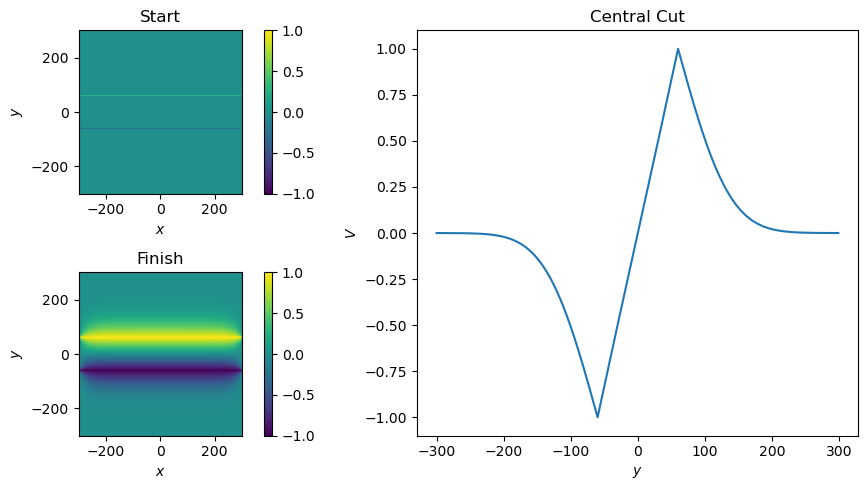

In [44]:
P, Q, R= callV3(300)
plot(P, Q, R)

As seen in the plots above, the potential does not go to 0 outside the infinite conducting planes (as it should). The use of periodic boundary conditions means that the electric field and potential created by the plates affect the entire grid. In a true infinite plane scenario, the fields from distant sections of the plane should cancel out, but in a finite grid this cancellation doesn't occur perfectly, meaning $V\neq0$ everywhere outside the plates.

Increasing the radius helps because it provides a larger simulation grid, which better approximates the behavior of an infinite system; With a larger radius, the pixels between the plates and the top/bottom boundaries increases, more accurately simulating an infinite plate.